### Import dependencies

Import the dependencies needed to build the model and set the key patterns for fetching data from the dataset.
Get info about the dataset.

In [46]:
import os
import logging

import pandas as pd
import numpy as np

import h5py
import threading
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

DEP_FEATURE_NAME = 'surf_temp_sqerror'
HDF_LOCK = threading.Lock()
DATE_PATTERN = 'date%Y%m%d'
TIME_PATTERN = 'time%H%M'
KEY_PATTERN = '/{}/{}'.format(DATE_PATTERN, TIME_PATTERN)
STORE_PATH = 'metro_error_data_pro_swe2018.h5'


log = logging.getLogger(__name__)

# print(pd.HDFStore(STORE_PATH, 'r').info())
# print('Done')

### Set the environment variables

Define the features needed from the dataset

In [302]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount', 'station_id']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = ['forecast_length'] + HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES
DEPENDENT_FEATURES = ['stn_{}'.format(f) for f in ['dew_point', 'surf_temp']]
ERROR_FEATURES = ['surf_temp_sqerror']

### Define the building functions

Define the functions needed to extract the dataset and train the model

In [303]:

start_time = datetime(2018, 9, 29, 5)
end_time = datetime(2018, 3, 14, 14)

def define_SSE(df, dep_feature_name):
    if dep_feature_name == 'surf_temp_sqerror':
        df[dep_feature_name] = (df['surf_temp'] - df['stn_surf_temp']) ** 2

def store_path(store_name):
    cwd = os.getcwd()
    return os.path.join(cwd, '{}.h5'.format(store_name))

def truncate_time(time):
    return time.replace(minute=10*(time.minute//10), second=0, microsecond=0)

def read(valid_time):
    valid_time = truncate_time(valid_time)
    with HDF_LOCK:
        with pd.HDFStore(STORE_PATH, 'r') as store:
            key = valid_time.strftime(KEY_PATTERN)
            if key in store:
                return store.get(key)

def gather_training_data(start_time, end_time):
    print('gathering training data from {} until {}'.format(start_time, end_time))
    ref_time = start_time
    dfs = []
    dfs.append(read(ref_time))
    df = pd.concat(dfs)
    print('Training data memory usage: {}Mb'.format(df.memory_usage().sum() / 10**6))
    return df

def train_test_splitter(df):
    define_target_features(df, dep_feature_name=DEP_FEATURE_NAME)
    return model

df.head()


,AirTemp,DewPoint,RainPrecip,SnowPrecip,SnowPrecipAccumulated,WindSpeed,AirPressure,OctalCloudCoverage,PrecipAmount,station_id,...,air_temp,dew_point,water_amount,snow_sum,forecast_length,stn_surf_temp,stn_dew_point,radiation,shade,surf_temp_sqerror
0,10.9,8.824256,0.0,-0.0,0.0,4.8,102630.0,0.0,0.0,1202,...,8.1,7.7,0.020,0.0,1,7.8,7.96,257.708954,0.0,0.078400
1,10.8,7.854865,0.0,-0.0,0.0,6.0,102650.0,0.0,0.0,1202,...,8.6,6.9,0.014,0.0,2,10.5,10.26,572.579224,0.0,1.690001
2,11.4,6.937371,0.0,-0.0,0.0,6.4,102670.0,1.0,0.0,1202,...,9.7,6.2,0.002,0.0,3,13.7,10.20,713.935120,0.0,3.385601
3,12.0,6.071365,0.0,-0.0,0.0,6.8,102670.0,3.0,0.0,1202,...,10.7,5.5,0.000,0.0,4,16.4,8.80,783.778503,0.0,4.368097
4,12.3,6.139616,0.0,-0.0,0.0,7.1,102659.0,3.0,0.0,1202,...,11.3,5.7,0.000,0.0,5,18.9,8.12,817.249634,0.0,7.452898


### Define the functions for training the model

Set the methods for training and returning the model

In [304]:
# Random Forest parameters
RFR_PARAMS = {
    'n_estimators': 60,
    'max_features': 'sqrt',
    'min_samples_leaf': 10,
    'max_depth': 8,
    'warm_start': True}

def train_feature_model(df, dep_feature_name, ind_feature_names=INDEPENDENT_FEATURES, params=RFR_PARAMS):
    print('training {} with a DataFrame of shape {}'.format(dep_feature_name, df.shape))
    included = np.array(df[ind_feature_names + [dep_feature_name]].notnull().all(axis=1))
    rfr = RandomForestRegressor(**params)
    rfr.fit(df.loc[included, ind_feature_names].values.astype(np.float),
            df.loc[included, dep_feature_name].values.astype(np.float))
    return rfr

def train_models(df):
    models = {}
    for dep_feature_name in ERROR_FEATURES:
        # ['surf_temp_sqerror']:
        define_SSE(df, dep_feature_name=dep_feature_name)
        models.update({dep_feature_name: train_feature_model(df=df, dep_feature_name=dep_feature_name)})
    return models

In [305]:
included = np.array(df[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
rsi = {
    "data": df.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
    "target": df.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
}

In [306]:
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(rsi["data"], rsi["target"], test_size=0.2, random_state=0)

rfr = RandomForestRegressor(**RFR_PARAMS).fit(X_train, y_train)

y_true = y_test
y_pred = rfr.predict(X_test)

mean_squared_error(y_true, y_pred)

34.346949512606315

Text(0.5, 0, 'surf_temp_sqerror')

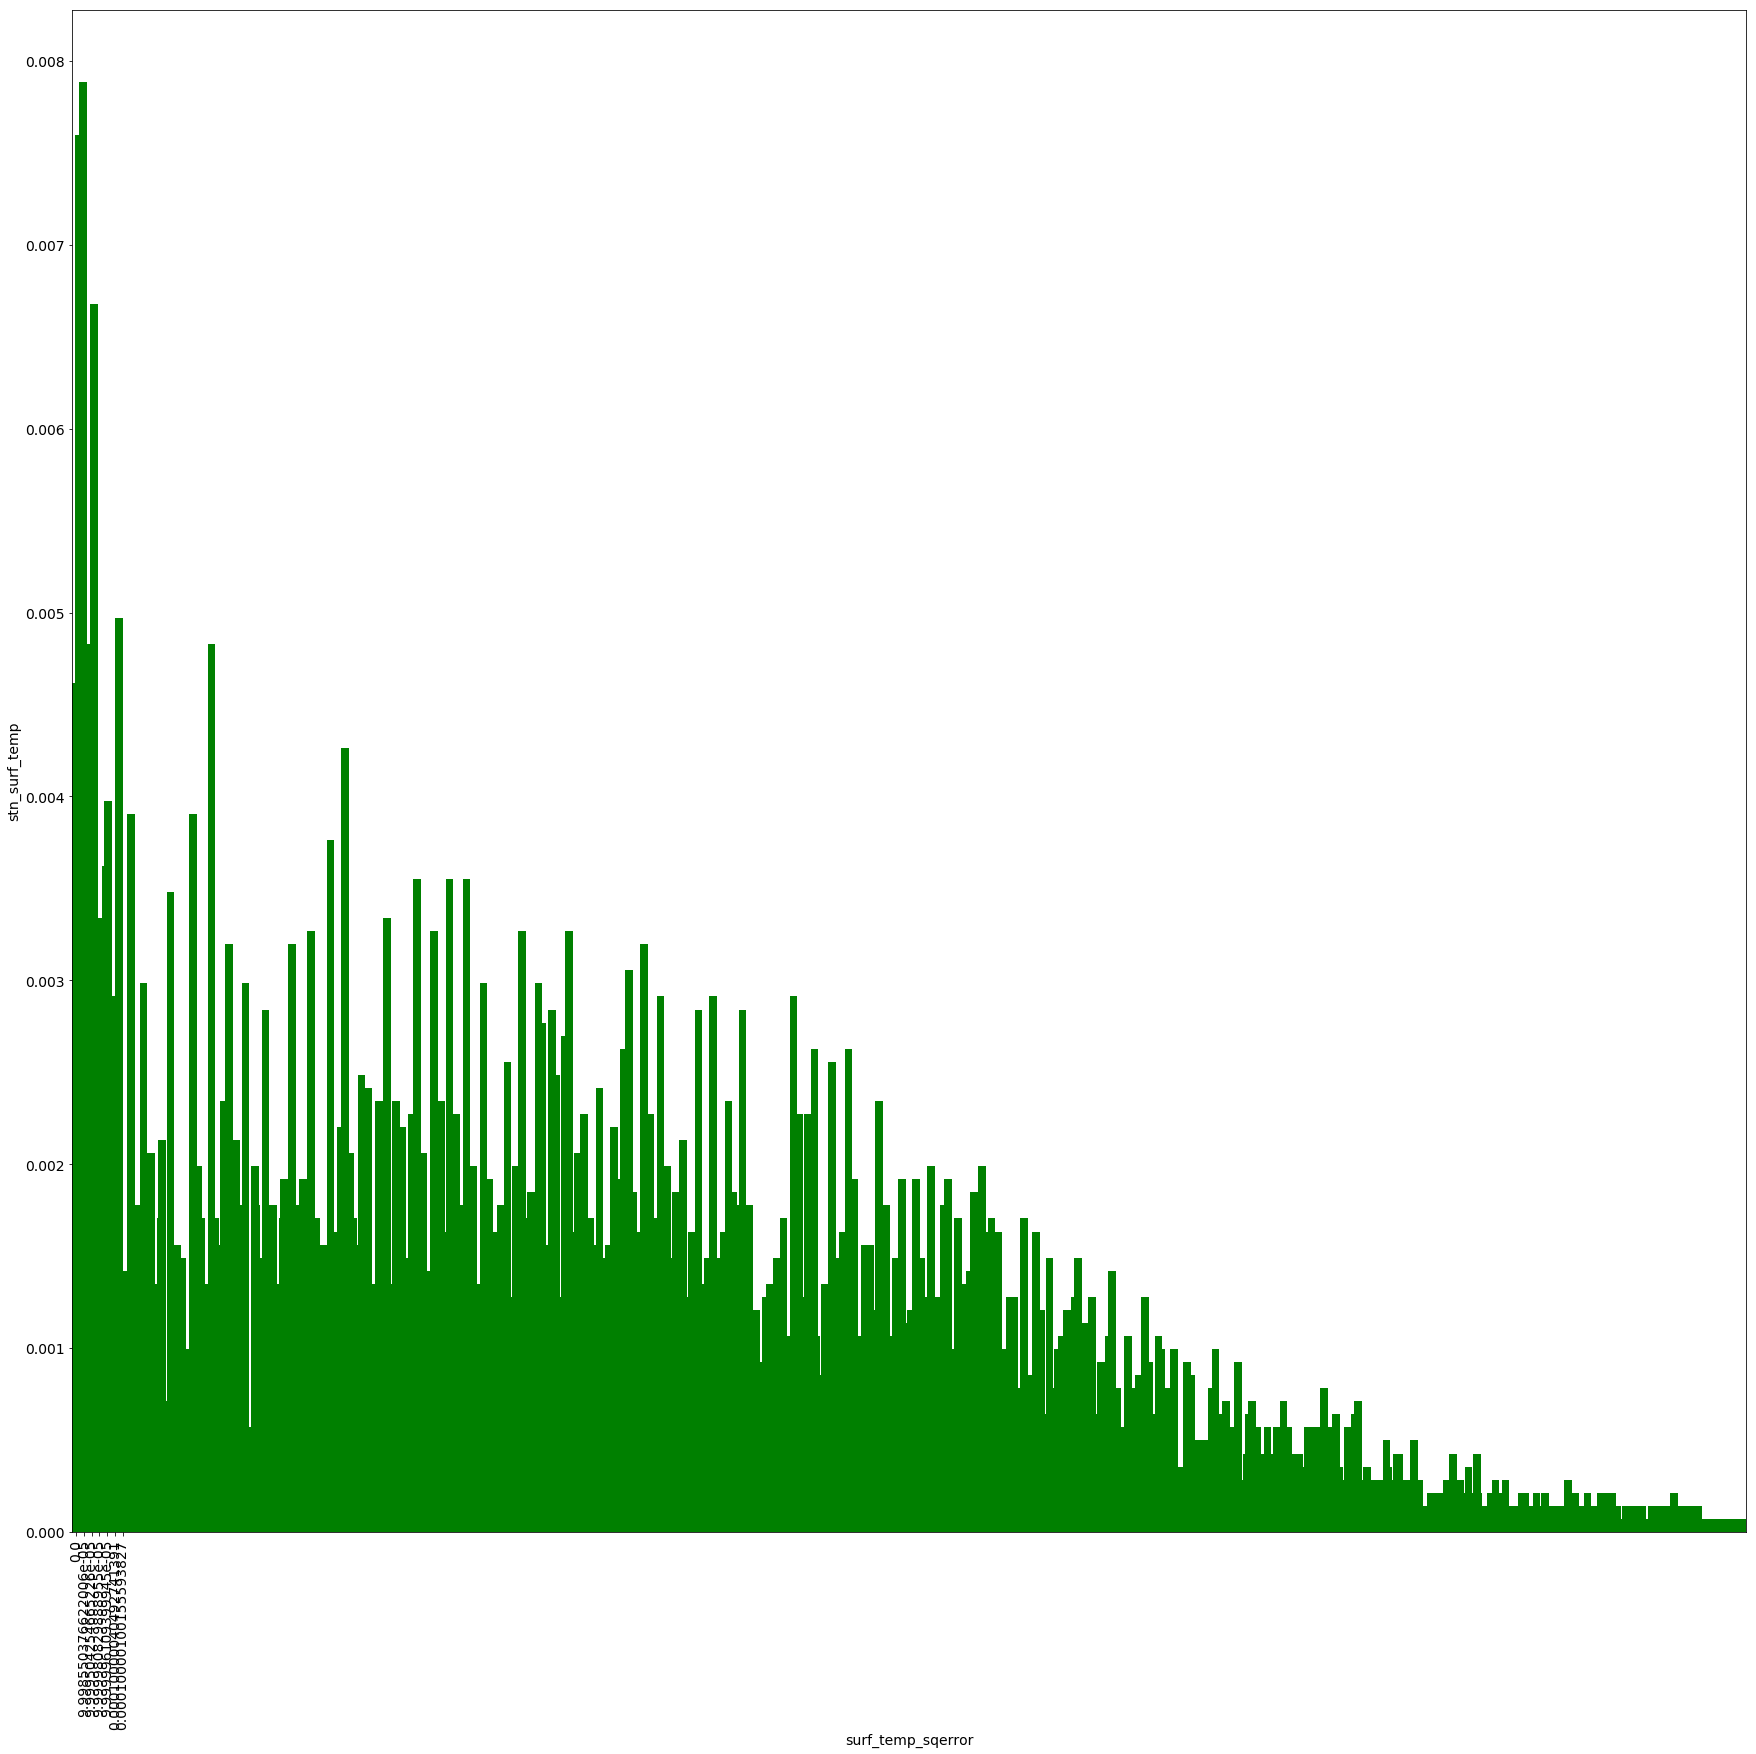

In [297]:
%matplotlib inline

for dep_feature_name in ERROR_FEATURES:
        # ['surf_temp_sqerror']:
        define_SSE(df, dep_feature_name=dep_feature_name)
       

df.head()

plt.figure(figsize=(30,28))
stat = df.groupby('surf_temp_sqerror')['surf_temp_sqerror'].agg(lambda x : float(len(x))/df.shape[0])
stat.plot(kind='bar', fontsize=14, width=10, color="green")
plt.xticks([0, 10, 20, 30, 40, 50, 60])
plt.ylabel('stn_surf_temp', fontsize=14)
plt.xlabel('surf_temp_sqerror', fontsize=14)

Text(0, 0.5, 'Estimated surf_temp_sqerror')

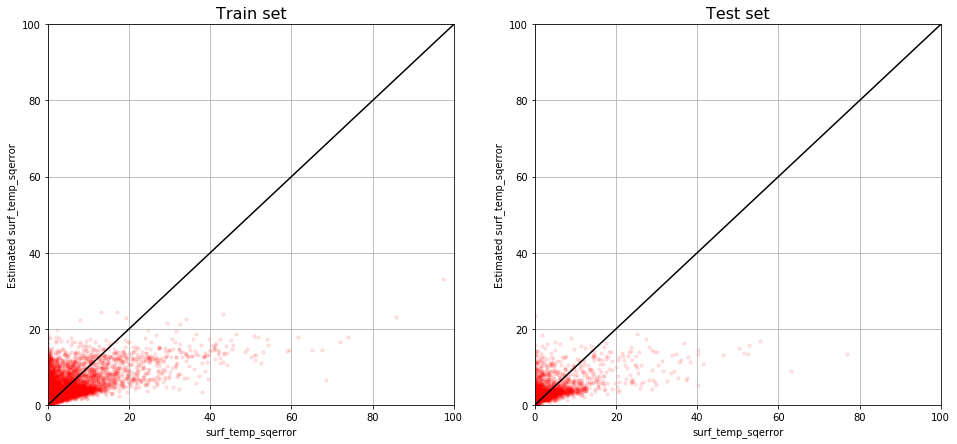

In [307]:
from matplotlib import pyplot

plt.figure(figsize=(16,7))
plt.subplot(121)
pyplot.scatter(y_train, rfr.predict(X_train), color="red", alpha=0.1, s=10)
pyplot.xlim(0,100)
pyplot.ylim(0,100)
pyplot.plot(range(110), color='black')
pyplot.grid()
pyplot.title('Train set', fontsize=16)
pyplot.xlabel('surf_temp_sqerror')
pyplot.ylabel('Estimated surf_temp_sqerror')

plt.subplot(122)
pyplot.scatter(y_test, rfr.predict(X_test), color="red", alpha=0.1, s=10)
pyplot.xlim(0,100)
pyplot.ylim(0,100)
pyplot.plot(range(110), color='black')
pyplot.grid()
pyplot.title('Test set', fontsize=16)
pyplot.xlabel('surf_temp_sqerror')
pyplot.ylabel('Estimated surf_temp_sqerror')

In [308]:
for name, value in zip(INDEPENDENT_FEATURES, rfr.feature_importances_):
    print('{}: {}'.format(name, value*100))

forecast_length: 8.836844658553314
radiation: 18.47626695819709
shade: 4.287912294542886
AirTemp: 5.745010710755091
DewPoint: 4.472683340572171
RainPrecip: 1.2282223103433267
SnowPrecip: 0.0449374855581206
SnowPrecipAccumulated: 0.05840580605967065
WindSpeed: 5.338885309366912
AirPressure: 5.5013588633959465
OctalCloudCoverage: 3.3271705454581317
PrecipAmount: 1.0864377653360897
station_id: 9.784703005939127
air_temp: 4.886576581939847
dew_point: 4.844870187460375
surf_temp: 7.501208278153627
water_amount: 8.792340130995541
snow_amount: 0.03629365296578835
sub_temp: 5.749872114406949
